### Fetch the data

I' going to use the free API from [sunrisesunset.io](https://sunrisesunset.io/api/) to fetch the sunrise/sunset times for the current year. 

In [165]:
import requests as r

from dataclasses import dataclass
from datetime import datetime, date, timedelta

@dataclass 
class Location: 
    lat: float
    lon: float 

@dataclass
class DayDuration: 
    date: date
    duration: timedelta

    def as_hours(self):
        return self.duration.seconds / 60 / 60


Helsinki = Location(lat=60.192059, lon=24.945831)


In [166]:
input_date_format = '%Y-%m-%d'
input_time_format = '%H:%M:%S'

def parse_api_date_object(obj): 
    parsed_date = datetime.strptime(obj['date'], input_date_format).date()
    day_length = datetime.strptime(obj['day_length'], input_time_format).time()
    day_duration = datetime.combine(date.min, day_length) - datetime.min
    return DayDuration(parsed_date, day_duration)


In [167]:
def get_year_bounds(ref_date): 
    start_of_year = date(ref_date.year, 1, 1)
    end_of_year = date(ref_date.year, 12, 31)
    return start_of_year, end_of_year

def get_request_url(location, date_start, date_end): 
    return "https://api.sunrisesunset.io/json?lat={}&lng={}&date_start={}&date_end={}".format(location.lat, location.lon, date_start, date_end)

def request_day_length_data(location): 
    date_start, date_end = get_year_bounds(datetime.now())
    response = r.get(get_request_url(location, date_start, date_end))
    assert response.status_code == 200, "Error code: " + str(response.status_code)

    json = response.json()
    assert json['status'] == 'OK'
    return [parse_api_date_object(obj) for obj in json['results']] 


### Plotting the day length data 

Let's make a plot to show us how the day length gets longer or shorter during the year 

In [168]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('ggplot')

Text(0, -20, '2024-10-28')

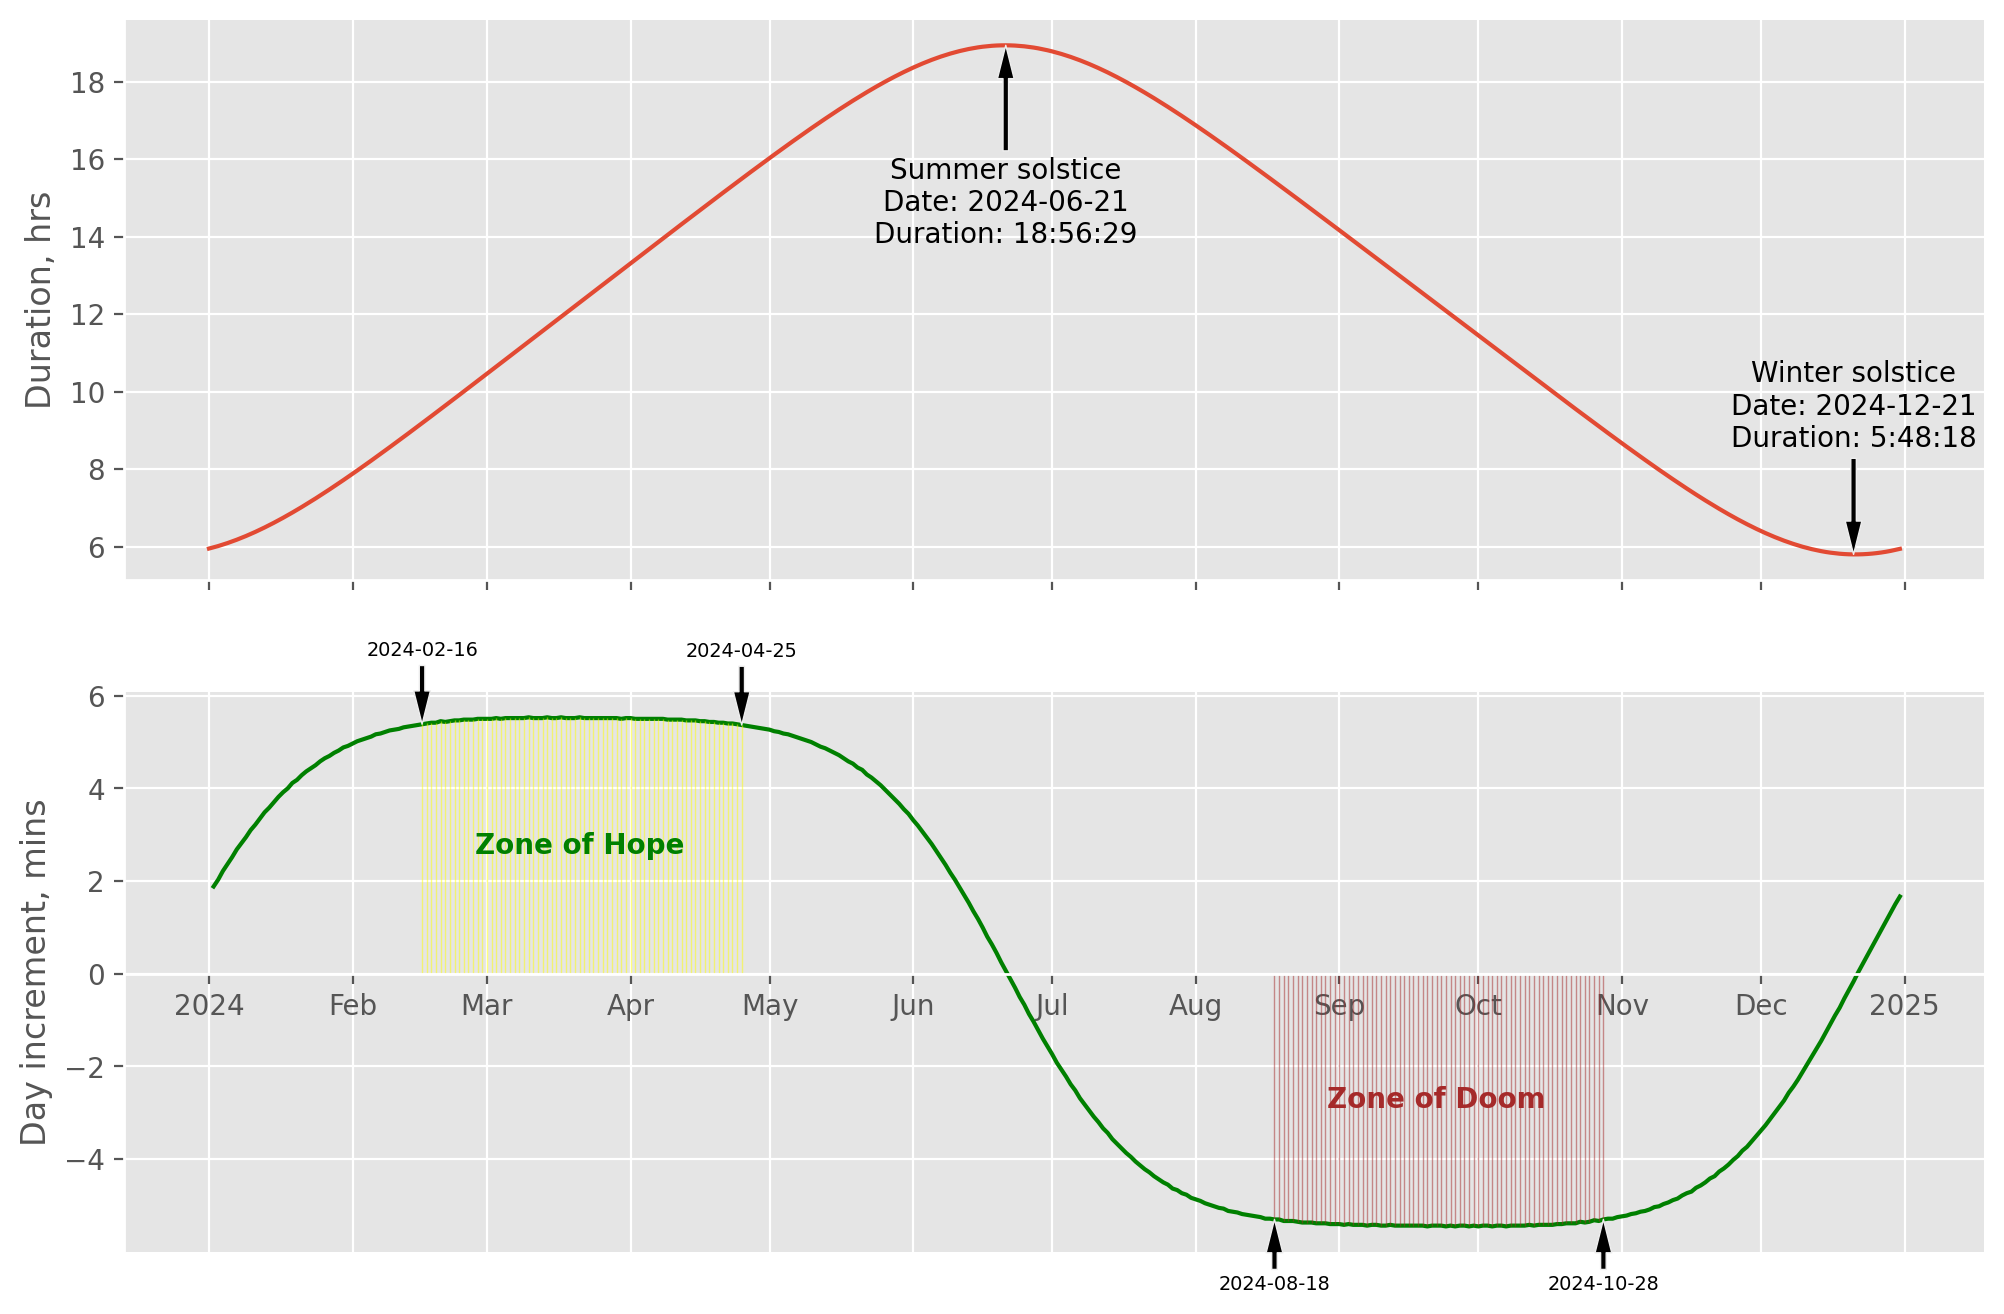

In [169]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('ggplot')

data = request_day_length_data(Helsinki)

xx = np.array([d.date for d in data])
duration_yy = np.array([d.as_hours() for d in data])
duration_incr_yy = np.ediff1d(duration_yy) * 60
summer_solstice_idx = np.argmax(duration_yy)
winter_solstice_idx = np.argmin(duration_yy)

fig, (ax1, ax2) = plt.subplots(figsize=(12, 8), nrows=2, sharex=True)

ax1.plot(xx, duration_yy)
ax1.set_ylabel('Duration, hrs')

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

summer_solstice = data[summer_solstice_idx]
winter_solstice = data[winter_solstice_idx]

ax1.annotate('Summer solstice\nDate: {}\nDuration: {}'.format(summer_solstice.date, summer_solstice.duration), 
             xy=(xx[summer_solstice_idx], duration_yy[summer_solstice_idx]), 
             xycoords='data',
             xytext=(0, -40),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6))

ax1.annotate('Winter solstice\nDate: {}\nDuration: {}'.format(winter_solstice.date, winter_solstice.duration), 
             xy=(xx[winter_solstice_idx], duration_yy[winter_solstice_idx]),
             xycoords='data',
             xytext=(0, 70),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6))


ax2.plot(xx[1:], duration_incr_yy, color='green')

ax2.set_ylabel('Day increment, mins')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position('zero')


max_incr = np.max(duration_incr_yy)
hope_condition = duration_incr_yy > (max_incr-10/60)
zone_of_hope_xx = xx[1:][hope_condition]
zone_of_hope_yy = duration_incr_yy[hope_condition]

ax2.vlines(zone_of_hope_xx, 0, zone_of_hope_yy, colors='yellow', alpha=0.5, linewidths=0.5)

zone_of_hope_mid_x = zone_of_hope_xx[0] + ((zone_of_hope_xx[-1] - zone_of_hope_xx[0]) / 2)

zone_of_hope_mid_y = max_incr / 2
ax2.text(zone_of_hope_mid_x, zone_of_hope_mid_y, 'Zone of Hope', fontweight='bold', ha='center', va='center', color='green')

max_decr = np.min(duration_incr_yy)
doom_condition = duration_incr_yy < (max_decr+10/60)
zone_of_doom_xx = xx[1:][doom_condition]
zone_of_doom_yy = duration_incr_yy[doom_condition]

ax2.vlines(zone_of_doom_xx, 0, zone_of_doom_yy, colors='brown', alpha=0.5, linewidths=0.5)

zone_of_doom_mid_x = zone_of_doom_xx[0] + ((zone_of_doom_xx[-1] - zone_of_doom_xx[0]) / 2)

zone_of_doom_mid_y = max_decr / 2
ax2.text(zone_of_doom_mid_x, zone_of_doom_mid_y, 'Zone of Doom', fontweight='bold', ha='center', va='center', color='brown')

ax2.annotate(str(zone_of_hope_xx[0]), 
             xy=(zone_of_hope_xx[0], zone_of_hope_yy[0]),
             xycoords='data',
             xytext=(0, 30),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize='x-small')

ax2.annotate(str(zone_of_hope_xx[-1]), 
             xy=(zone_of_hope_xx[-1], zone_of_hope_yy[-1]),
             xycoords='data',
             xytext=(0, 30),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize='x-small')


ax2.annotate(str(zone_of_doom_xx[0]), 
             xy=(zone_of_doom_xx[0], zone_of_doom_yy[0]),
             xycoords='data',
             xytext=(0, -20),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize='x-small')

ax2.annotate(str(zone_of_doom_xx[-1]), 
             xy=(zone_of_doom_xx[-1], zone_of_doom_yy[-1]),
             xycoords='data',
             xytext=(0, -20),
             textcoords='offset points',
             va='top', ha='center', 
             arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize='x-small')
